## Importing the necessary libraries & loading the dataset

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

dataset_pathname = 'drive/MyDrive/dataset.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reading the dataset

In [ ]:
df = pd.read_excel(dataset_pathname)
df.head()

,person_name,event_ts,location
0,7_1_0032247,2024-08-28 13:22:50.781355+00,"['25.268293, 55.297596']"
1,3_3_0105341,2024-08-28 13:22:36.407468+00,"['25.268017, 55.297518']"
2,3_3_0103424,2024-08-28 13:22:39.372381+00,"['25.271235, 55.301078']"
3,4_3_0114500,2024-08-28 13:23:00.928218+00,"['25.267324, 55.29629']"
4,9_2_0073534,2024-08-28 13:25:31.105655+00,"['25.271488, 55.305731']"


## Processing person_name column
- First we start by eliminating the rows that has string name instead of an id in the person_name column
- We then sort the values to get a time-arranged events for each person
- We convert person_name to person_id an keep track of the original id for decoding the data in the future

In [ ]:
df = df[[row['person_name'][0].isdigit() for index, row in df.iterrows()]]

## Removing timezone part from event_ts column
df['event_ts'] = df['event_ts'].str[:-3]

df = df.sort_values(['person_name', 'event_ts'], ascending=True)

repetitions = df['person_name'].value_counts()
df = df[df['person_name'].isin(repetitions[repetitions > 10].index)]

print(df)

        person_name                    event_ts                  location
475530  0_0_0000022  2024-07-29 06:03:51.241848   ['25.269209, 55.29728']
583118  0_0_0000022  2024-07-29 17:19:11.696686  ['25.271235, 55.301078']
584431  0_0_0000022  2024-07-29 17:22:51.017852  ['25.271235, 55.301078']
601101  0_0_0000022  2024-07-29 19:07:46.194134  ['25.271066, 55.304965']
618789  0_0_0000022  2024-07-30 03:38:53.613805  ['25.268209, 55.296546']
...             ...                         ...                       ...
312374  9_6_0205984  2024-08-31 13:39:46.250413  ['25.268017, 55.297518']
313444  9_6_0205984  2024-08-31 13:49:41.336281  ['25.268017, 55.297518']
351660  9_6_0205984  2024-08-31 17:11:56.768021   ['25.269209, 55.29728']
409730  9_6_0205984  2024-09-02 06:00:00.011919  ['25.269783, 55.297836']
449278  9_6_0205984  2024-09-03 06:02:48.738925  ['25.269783, 55.297836']

[489831 rows x 3 columns]


## Spliting latitude & longitude

In [ ]:
latitude = df['location'].str.split(', ', expand=True)[0]
longitude = df['location'].str.split(', ', expand=True)[1]

df['latitude'] = latitude.str[2:].apply(pd.to_numeric)
df['longitude'] = longitude.str[:-2].apply(pd.to_numeric)

df = df.drop('location', axis=1)

print(df)

        person_name                    event_ts   latitude  longitude
475530  0_0_0000022  2024-07-29 06:03:51.241848  25.269209  55.297280
583118  0_0_0000022  2024-07-29 17:19:11.696686  25.271235  55.301078
584431  0_0_0000022  2024-07-29 17:22:51.017852  25.271235  55.301078
601101  0_0_0000022  2024-07-29 19:07:46.194134  25.271066  55.304965
618789  0_0_0000022  2024-07-30 03:38:53.613805  25.268209  55.296546
...             ...                         ...        ...        ...
312374  9_6_0205984  2024-08-31 13:39:46.250413  25.268017  55.297518
313444  9_6_0205984  2024-08-31 13:49:41.336281  25.268017  55.297518
351660  9_6_0205984  2024-08-31 17:11:56.768021  25.269209  55.297280
409730  9_6_0205984  2024-09-02 06:00:00.011919  25.269783  55.297836
449278  9_6_0205984  2024-09-03 06:02:48.738925  25.269783  55.297836

[489831 rows x 4 columns]


## Ploting histogram

In [ ]:
sns.histplot(data=df, x='person_name')
plt.show()

KeyboardInterrupt: 

## Normalizing the data

In [ ]:
def normalize(data):
  min = data.min()
  max = data.max()

  return (data - min) / (max - min)

df['latitude'] = normalize(df['latitude'])
df['longitude'] = normalize(df['longitude'])

print(df)

        person_name                    event_ts  latitude  longitude
475530  0_0_0000022  2024-07-29 06:03:51.241848  0.377796   0.122791
583118  0_0_0000022  2024-07-29 17:19:11.696686  0.750623   0.461717
584431  0_0_0000022  2024-07-29 17:22:51.017852  0.750623   0.461717
601101  0_0_0000022  2024-07-29 19:07:46.194134  0.719524   0.808585
618789  0_0_0000022  2024-07-30 03:38:53.613805  0.193775   0.057291
...             ...                         ...       ...        ...
312374  9_6_0205984  2024-08-31 13:39:46.250413  0.158442   0.144030
313444  9_6_0205984  2024-08-31 13:49:41.336281  0.158442   0.144030
351660  9_6_0205984  2024-08-31 17:11:56.768021  0.377796   0.122791
409730  9_6_0205984  2024-09-02 06:00:00.011919  0.483424   0.172408
449278  9_6_0205984  2024-09-03 06:02:48.738925  0.483424   0.172408

[489831 rows x 4 columns]



## Clustering latitude and longitude

By plotting the relation between latitude and longitude we notice that we can cluster them into locations for more accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'Data after clustering')

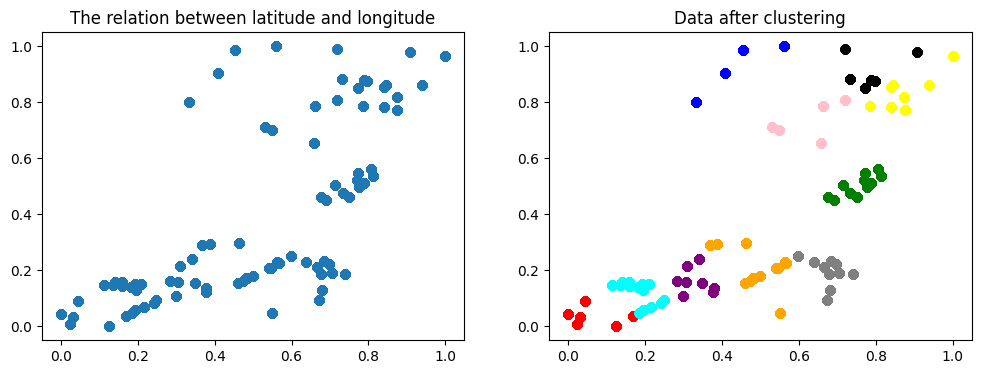

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12, 4))
axs[0].scatter(df['latitude'], df['longitude'])
axs[0].set_title('The relation between latitude and longitude')

n_clusters = 10
cluster = KMeans(n_clusters)
location_cluster = cluster.fit_predict(df[['latitude', 'longitude']])

df['location_cluster'] = location_cluster

colors = ['red', 'green', 'black', 'orange', 'blue', 'gray', 'cyan', 'pink', 'purple', 'yellow']

for i in range(0, n_clusters):
  df_plot = df[df['location_cluster'] == i]
  axs[1].scatter(df_plot['latitude'], df_plot['longitude'], color=colors[i])

axs[1].set_title('Data after clustering')

## Getting next place for each person by
- Shifting the values to the left
- Eliminating the last row for each person for lack of information

In [ ]:
df['next_location_cluster'] = df['location_cluster'].shift(-1)
df['location_cluster'] = normalize(df['location_cluster'])
df['next_location_cluster'] = normalize(df['next_location_cluster'])

grouped_df = df.groupby("person_name")

modified_df = []

# Deleting the last row
for person_name, group in grouped_df:
  group = group.iloc[:-1]
  modified_df.append(group)

df = pd.concat(modified_df)
df.reset_index(inplace=True)

# making sure we have the latest update in the dataset
grouped_df = df.groupby("person_name")
splited_dataframes = {group_name: group for group_name, group in grouped_df}
print(df)

         index  person_name                    event_ts  latitude  longitude  \
0       475530  0_0_0000022  2024-07-29 06:03:51.241848  0.377796   0.122791   
1       583118  0_0_0000022  2024-07-29 17:19:11.696686  0.750623   0.461717   
2       584431  0_0_0000022  2024-07-29 17:22:51.017852  0.750623   0.461717   
3       601101  0_0_0000022  2024-07-29 19:07:46.194134  0.719524   0.808585   
4       618789  0_0_0000022  2024-07-30 03:38:53.613805  0.193775   0.057291   
...        ...          ...                         ...       ...        ...   
472002  186460  9_6_0205984  2024-08-30 11:03:34.109033  0.770130   0.520703   
472003  312374  9_6_0205984  2024-08-31 13:39:46.250413  0.158442   0.144030   
472004  313444  9_6_0205984  2024-08-31 13:49:41.336281  0.158442   0.144030   
472005  351660  9_6_0205984  2024-08-31 17:11:56.768021  0.377796   0.122791   
472006  409730  9_6_0205984  2024-09-02 06:00:00.011919  0.483424   0.172408   

        location_cluster  next_location

## Spliting data into inputs and outputs

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

x = []
y = []
data = []

n_input = 3
n_output = 1

# Looping over each person location history to make sure we get a correct sequence
for group_name, group in splited_dataframes.items():
  for i in range(len(group) - n_input):
    corrected_index = i + group.index[0]

    x.append([])

    x[-1].append(group.at[corrected_index, 'location_cluster'])
    x[-1].append(group.at[corrected_index + 1, 'location_cluster'])
    x[-1].append(group.at[corrected_index + 2, 'location_cluster'])
    y.append(group.at[corrected_index + 3, 'location_cluster'])

    if (i + 1 == len(group) - n_input):
      data.append(group.at[corrected_index, 'location_cluster'])
      data.append(group.at[corrected_index + 1, 'location_cluster'])
      data.append(group.at[corrected_index + 2, 'location_cluster'])
    elif (i % n_input == 0):
      data.append(group.at[corrected_index, 'location_cluster'])
    else:
      data.append(group.at[corrected_index, 'location_cluster'])

print(data[-10:])

data = data[:100003]
generator = TimeseriesGenerator(data, data, length=n_input, batch_size=1)

t,r = generator[0]
print(t.flatten(), r)

print(f'Input items count: {len(x)}')
print(f'Output items count: {len(y)}')

# Limiting Printed values count for performance
print(f'Inputs:  {x[-10:]}')
print(f'Outputs: {y[-10:]}')


[0.1111111111111111, 0.1111111111111111, 0.5555555555555556, 0.6666666666666666, 1.0, 0.3333333333333333, 0.1111111111111111, 0.6666666666666666, 0.6666666666666666, 0.8888888888888888]
[0.88888889 0.11111111 0.11111111] [0.77777778]
Input items count: 418535
Output items count: 418535
Inputs:  [[0.3333333333333333, 0.2222222222222222, 0.1111111111111111], [0.2222222222222222, 0.1111111111111111, 0.1111111111111111], [0.1111111111111111, 0.1111111111111111, 0.5555555555555556], [0.1111111111111111, 0.5555555555555556, 0.6666666666666666], [0.5555555555555556, 0.6666666666666666, 1.0], [0.6666666666666666, 1.0, 0.3333333333333333], [1.0, 0.3333333333333333, 0.1111111111111111], [0.3333333333333333, 0.1111111111111111, 0.6666666666666666], [0.1111111111111111, 0.6666666666666666, 0.6666666666666666], [0.6666666666666666, 0.6666666666666666, 0.8888888888888888]]
Outputs: [0.1111111111111111, 0.5555555555555556, 0.6666666666666666, 1.0, 0.3333333333333333, 0.1111111111111111, 0.66666666666

## Spliting the dataset into Training & Testing

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

## Training LSTM model


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_output)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.fit(generator, epochs=50)

Epoch 1/50
100000/100000 ━━━━━━━━━━━━━━━━━━━━ 561s 6ms/step - loss: 0.1072
Epoch 2/50
100000/100000 ━━━━━━━━━━━━━━━━━━━━ 524s 5ms/step - loss: 0.1066
Epoch 3/50
100000/100000 ━━━━━━━━━━━━━━━━━━━━ 539s 5ms/step - loss: 0.1070
Epoch 4/50
100000/100000 ━━━━━━━━━━━━━━━━━━━━ 552s 5ms/step - loss: 0.1071
Epoch 5/50
100000/100000 ━━━━━━━━━━━━━━━━━━━━ 532s 5ms/step - loss: 0.1070
Epoch 6/50
100000/100000 ━━━━━━━━━━━━━━━━━━━━ 575s 5ms/step - loss: 0.1063
Epoch 7/50
100000/100000 ━━━━━━━━━━━━━━━━━━━━ 546s 5ms/step - loss: 0.1064
Epoch 8/50
100000/100000 ━━━━━━━━━━━━━━━━━━━━ 576s 5ms/step - loss: 0.1063
Epoch 9/50
   742/100000 ━━━━━━━━━━━━━━━━━━━━ 10:02 6ms/step - loss: 0.1022

KeyboardInterrupt: 

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [ ]:
result = model.predict(x_test[0])
print(f'Prediction: {result}')
print(f'Actual: {y_test[0]}')

## Training the model

In [ ]:
n_input = 3
n_output = 1

generator = tf.keras.utils.timeseries_dataset_from_array(
    data,
    data,
    sequence_length=n_input,
    batch_size=1)

## Dropping unneeded columns

In [ ]:
df.nunique()

In [ ]:
columns_to_drop = df.filter(regex="person_name|latitude|longitude", axis=1)
df = df.drop(columns_to_drop.columns, axis=1)

## Assuring no null values exist in the dataset

In [ ]:
df.dropna(inplace=True)
df.reset_index(inplace=True)

print(df)

## writing the result in an excel file

In [ ]:
df.to_excel(r'./processed-dataset.xlsx', index=None)